In [14]:
# libraries import 

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
# import ensemble methods
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
# import base estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" 

## EDA 

In [15]:
data = pd.read_csv('conversion_data_train.csv')
# Basic stats
print("Number of rows : {}".format(data.shape[0]))
print("Number of columns : {}".format(len(data.columns)))
print()

print("Display of dataset: ")
display(data.head())
print()

print("Basics statistics: ")
data_desc = data.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*data.isnull().sum()/data.shape[0])

Number of rows : 284580
Number of columns : 6

Display of dataset: 


,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0



Basics statistics: 


,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000



Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

In [16]:
# explore dataset

# The dataset is quite big : we create a sample of the dataset before making visualizations
data_sample = data.sample(10000)

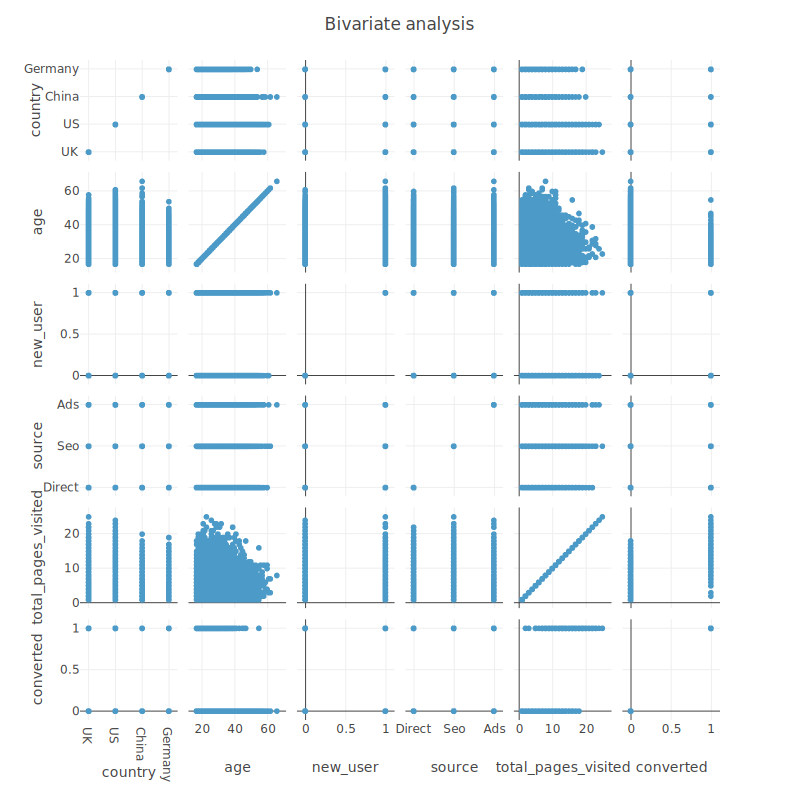

In [19]:
# Visualize pairwise dependencies
fig = px.scatter_matrix(data_sample)
fig.update_layout(
        title = go.layout.Title(text = "Bivariate analysis", x = 0.5), showlegend = False, 
            autosize=False, height=800, width = 800)
fig.show()

We can't see real interdependencies between the variables.

## Preprocessing 

In [20]:
# Separate target variable Y from features X
print("Separating labels from features...")
target_variable = "converted"

X = data.drop(target_variable, axis = 1)
Y = data.loc[:,target_variable]
print("Labels separated")

# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify = Y)
print("...Done.")
print()

# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' mean
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = OneHotEncoder(drop='first') 

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

Separating labels from features...
Labels separated
Found numeric features  ['age', 'new_user', 'total_pages_visited']
Found categorical features  ['country', 'source']
Dividing into train and test sets...
...Done.



In [21]:
# Preprocessings on train set
print("Performing preprocessings on train set...")

X_train = preprocessor.fit_transform(X_train)
print("...Done")
print("Encoding labels...")

encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("...Done")


# Preprocessings on test set
print("Performing preprocessings on test set...")

X_test = preprocessor.transform(X_test)
print('...Done.')

# Label encoding
print("Encoding labels...")

Y_test = encoder.transform(Y_test)
print("...Done")

Performing preprocessings on train set...
...Done
Encoding labels...
...Done
Performing preprocessings on test set...
...Done.
Encoding labels...
...Done


## Model baseline

In [22]:
# Train model
print("Train models...")
LogReg = LogisticRegression()
LogReg.fit(X_train, Y_train)


DecTree = DecisionTreeClassifier()
DecTree.fit(X_train, Y_train)

print("...Done.")

Train models...
...Done.


In [23]:
# Predictions on training set
Y_train_pred_LogReg = LogReg.predict(X_train)
Y_test_pred_LogReg = LogReg.predict(X_test)

Y_train_pred_DecTree = DecTree.predict(X_train)
Y_test_pred_DecTree = DecTree.predict(X_test)


print("Logistic Regression f1-score on train set : ", f1_score(Y_train, Y_train_pred_LogReg))
print("Logistic Regression f1-score on test set : ", f1_score(Y_test, Y_test_pred_LogReg))
print( )
print("Decision Tree f1-score on train set : ", f1_score(Y_train, Y_train_pred_DecTree))
print("Decision Tree f1-score on test set : ", f1_score(Y_test, Y_test_pred_DecTree))



Logistic Regression f1-score on train set :  0.7642058764473596
Logistic Regression f1-score on test set :  0.7595396729254997

Decision Tree f1-score on train set :  0.7983466594389484
Decision Tree f1-score on test set :  0.7198038013488657


# Model improve

## Bagging

In [32]:
# Perform grid search
print("Grid search...")
logreg = LogisticRegression(max_iter = 1000) # max_iter changed because of convergence warning
model = BaggingClassifier(logreg)

# Grid of values to be tested
params = {
    'base_estimator__C': [0.5, 0.55, 0.555, 0.6, 0.7], # base_estimator__ prefix because C is a parameter from LogisticRegression! 
    'n_estimators': [10, 20, 25, 30] # n_estimators is a hyperparameter of the ensemble method
}
print(params)
gridsearch_bag_logreg = GridSearchCV(model, param_grid = params, n_jobs=-1, scoring='f1',verbose=2) 
gridsearch_bag_logreg.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_bag_logreg.best_params_)
print("Best validation F1 : ", gridsearch_bag_logreg.best_score_)
print()
print("F1 on training set : ", gridsearch_bag_logreg.score(X_train, Y_train))
print("F1 on test set : ", gridsearch_bag_logreg.score(X_test, Y_test))

Grid search...
{'base_estimator__C': [0.5, 0.55, 0.555, 0.6, 0.7], 'n_estimators': [10, 20, 25, 30]}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/marieagrapart/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/marieagrapart/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/marieagrapart/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/marieagrapart/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detect

[CV] END .............base_estimator__C=0.5, n_estimators=10; total time=  18.0s
[CV] END .............base_estimator__C=0.5, n_estimators=10; total time=  19.3s
[CV] END .............base_estimator__C=0.5, n_estimators=10; total time=  19.5s
[CV] END .............base_estimator__C=0.5, n_estimators=10; total time=  20.2s
[CV] END .............base_estimator__C=0.5, n_estimators=10; total time=  20.8s
[CV] END .............base_estimator__C=0.5, n_estimators=20; total time=  34.3s
[CV] END .............base_estimator__C=0.5, n_estimators=20; total time=  35.0s
[CV] END .............base_estimator__C=0.5, n_estimators=20; total time=  36.0s
[CV] END .............base_estimator__C=0.5, n_estimators=20; total time=  30.8s
[CV] END .............base_estimator__C=0.5, n_estimators=20; total time=  29.6s
[CV] END .............base_estimator__C=0.5, n_estimators=25; total time=  35.7s
[CV] END .............base_estimator__C=0.5, n_estimators=25; total time=  35.4s
[CV] END .............base_e

In [25]:
# Perform grid search
print("Grid search...")
decision_tree = DecisionTreeClassifier()
model = BaggingClassifier(decision_tree)

# Grid of values to be tested
params = {
    'base_estimator__max_depth': [3, 4],
    'base_estimator__min_samples_leaf': [1, 2],
    'base_estimator__min_samples_split': [1, 2, 3],
    'n_estimators': [1, 2, 4]
}
print(params)
gridsearch_bag_tree = GridSearchCV(model, param_grid = params, n_jobs=-1, scoring='f1',verbose=2) 
gridsearch_bag_tree.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_bag_tree.best_params_)
print("Best validation F1 : ", gridsearch_bag_tree.best_score_)
print()
print("F1 on training set : ", gridsearch_bag_tree.score(X_train, Y_train))
print("F1 on test set : ", gridsearch_bag_tree.score(X_test, Y_test))

Grid search...
{'base_estimator__max_depth': [3, 4], 'base_estimator__min_samples_leaf': [1, 2], 'base_estimator__min_samples_split': [1, 2, 3], 'n_estimators': [1, 2, 4]}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=1, n_estimators=1; total time=   0.3s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=1, n_estimators=1; total time=   0.4s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=1, n_estimators=1; total time=   0.4s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=1, n_estimators=2; total time=   0.3s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=1, n_estimators=1; total time=   0.3s
[CV] END base_estimator__max_depth=3

/Users/marieagrapart/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/marieagrapart/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/marieagrapart/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py", line 269, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/marieagrapart/opt/anaconda3/lib/python3.9/site-packages/skle

...Done.
Best hyperparameters :  {'base_estimator__max_depth': 3, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'n_estimators': 1}
Best validation F1 :  0.7300267776281895

F1 on training set :  0.728192507519825
F1 on test set :  0.7254658385093169


# Boosting with AdaBoost

In [26]:
# Perform grid search
print("Grid search...")
logreg = LogisticRegression(max_iter = 1000) # max_iter changed because of convergence warning
model = AdaBoostClassifier(logreg)

# Grid of values to be tested
params = {
    'base_estimator__C': [0.01, 0.05, 0.1, 0.5,0.55],
    'n_estimators': [5, 10, 20, 30] 
}
print(params)
gridsearch_boost_logreg = GridSearchCV(model, param_grid = params, n_jobs=-1, scoring='f1',verbose=2) 
gridsearch_boost_logreg.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_boost_logreg.best_params_)
print("Best validation F1 : ", gridsearch_boost_logreg.best_score_)
print()
print("F1 on training set : ", gridsearch_boost_logreg.score(X_train, Y_train))
print("F1 on test set : ", gridsearch_boost_logreg.score(X_test, Y_test))

Grid search...
{'base_estimator__C': [0.01, 0.05, 0.1, 0.5, 0.55], 'n_estimators': [5, 10, 20, 30]}
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END .............base_estimator__C=0.01, n_estimators=5; total time=   1.9s
[CV] END .............base_estimator__C=0.01, n_estimators=5; total time=   1.9s
[CV] END .............base_estimator__C=0.01, n_estimators=5; total time=   1.9s
[CV] END .............base_estimator__C=0.01, n_estimators=5; total time=   2.0s
[CV] END .............base_estimator__C=0.01, n_estimators=5; total time=   1.9s
[CV] END ............base_estimator__C=0.01, n_estimators=10; total time=   3.6s
[CV] END ............base_estimator__C=0.01, n_estimators=10; total time=   3.6s
[CV] END ............base_estimator__C=0.01, n_estimators=10; total time=   4.0s
[CV] END ............base_estimator__C=0.01, n_estimators=10; total time=   3.4s
[CV] END ............base_estimator__C=0.01, n_estimators=10; total time=   3.6s
[CV] END ............base_es

In [27]:
# Perform grid search
print("Grid search...")
decision_tree = DecisionTreeClassifier()
model = AdaBoostClassifier(decision_tree)

# Grid of values to be tested
params = {
    'base_estimator__max_depth': [1, 2, 3],
    'base_estimator__min_samples_leaf': [1, 2, 3],
    'base_estimator__min_samples_split': [2, 3, 4],
    'n_estimators': [2, 4, 6, 8, 10]
}
print(params)
gridsearch_boost_tree = GridSearchCV(model, param_grid = params,n_jobs=-1, scoring='f1',verbose=2) 
gridsearch_boost_tree.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_boost_tree.best_params_)
print("Best validation f1 : ", gridsearch_boost_tree.best_score_)
print()
print("F1 on training set : ", gridsearch_boost_tree.score(X_train, Y_train))
print("F1 on test set : ", gridsearch_boost_tree.score(X_test, Y_test))

Grid search...
{'base_estimator__max_depth': [1, 2, 3], 'base_estimator__min_samples_leaf': [1, 2, 3], 'base_estimator__min_samples_split': [2, 3, 4], 'n_estimators': [2, 4, 6, 8, 10]}
Fitting 5 folds for each of 135 candidates, totalling 675 fits
[CV] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=2, n_estimators=2; total time=   0.5s
[CV] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=2, n_estimators=2; total time=   0.6s
[CV] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=2, n_estimators=2; total time=   0.5s
[CV] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=2, n_estimators=2; total time=   0.5s
[CV] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=2, n_estimators=2; total time=   0.6s
[CV] END base_estimato

# XGBoost

In [28]:
# Perform grid search
print("Grid search...")
xgboost = XGBClassifier()

# Grid of values to be tested
params = {
    'max_depth': [2, 4, 6], # exactly the same role as in scikit-learn
    'min_child_weight': [1, 2, 3], # effect is more or less similar to min_samples_leaf and min_samples_split
    'n_estimators': [2, 4, 6, 8,] # exactly the same role as in scikit-learn
}
print(params)
gridsearch_xgboost = GridSearchCV(xgboost, param_grid = params, n_jobs=-1, scoring='f1',verbose=2)
gridsearch_xgboost.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_xgboost.best_params_)
print("Best validation f1 : ", gridsearch_xgboost.best_score_)
print()
print("F1 on training set : ", gridsearch_xgboost.score(X_train, Y_train))
print("F1 on test set : ", gridsearch_xgboost.score(X_test, Y_test))

Grid search...
{'max_depth': [2, 4, 6], 'min_child_weight': [1, 2, 3], 'n_estimators': [2, 4, 6, 8]}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END ....max_depth=2, min_child_weight=1, n_estimators=2; total time=   0.7s
[CV] END ....max_depth=2, min_child_weight=1, n_estimators=2; total time=   0.7s
[CV] END ....max_depth=2, min_child_weight=1, n_estimators=2; total time=   0.7s
[CV] END ....max_depth=2, min_child_weight=1, n_estimators=2; total time=   0.6s
[CV] END ....max_depth=2, min_child_weight=1, n_estimators=4; total time=   0.9s
[CV] END ....max_depth=2, min_child_weight=1, n_estimators=4; total time=   0.9s
[CV] END ....max_depth=2, min_child_weight=1, n_estimators=2; total time=   0.8s
[CV] END ....max_depth=2, min_child_weight=1, n_estimators=4; total time=   0.8s
[CV] END ....max_depth=2, min_child_weight=1, n_estimators=4; total time=   0.7s
[CV] END ....max_depth=2, min_child_weight=1, n_estimators=4; total time=   0.7s
[CV] END ....max_depth=2, m

# Compare our F1 score

In [33]:
print("Logistic Regression f1-score on train set : ", f1_score(Y_train, Y_train_pred_LogReg))
print("Logistic Regression f1-score on test set : ", f1_score(Y_test, Y_test_pred_LogReg))
print( )
print("Decision Tree f1-score on train set : ", f1_score(Y_train, Y_train_pred_DecTree))
print("Decision Tree f1-score on test set : ", f1_score(Y_test, Y_test_pred_DecTree))
print( )
print('Bagging')
print("Bagging with Logistic Regression F1 on training set : ", gridsearch_bag_logreg.score(X_train, Y_train))
print("Bagging with Logistic Regression F1 on test set : ", gridsearch_bag_logreg.score(X_test, Y_test))
print( )
print("Bagging with Decision Tree F1 on training set : ", gridsearch_bag_tree.score(X_train, Y_train))
print("Bagging with Decision Tree F1 F1 on test set : ", gridsearch_bag_tree.score(X_test, Y_test))
print( )
print('Boosting')
print("Adaboost Logistic Regression F1 on training set : ", gridsearch_boost_logreg.score(X_train, Y_train))
print("Adaboost Logistic Regression F1 on test set : ", gridsearch_boost_logreg.score(X_test, Y_test))
print( )
print("Adaboost Decision Tree F1 on training set : ", gridsearch_boost_tree.score(X_train, Y_train))
print("Adaboost Decision Tree F1 on test set : ", gridsearch_boost_tree.score(X_test, Y_test))
print( )
print("XGboost F1 on training set : ", gridsearch_xgboost.score(X_train, Y_train))
print("XGboost F1 on test set : ", gridsearch_xgboost.score(X_test, Y_test))


Logistic Regression f1-score on train set :  0.7642058764473596
Logistic Regression f1-score on test set :  0.7595396729254997

Decision Tree f1-score on train set :  0.7983466594389484
Decision Tree f1-score on test set :  0.7198038013488657

Bagging
Bagging with Logistic Regression F1 on training set :  0.7639410187667561
Bagging with Logistic Regression F1 on test set :  0.7595396729254997

Bagging with Decision Tree F1 on training set :  0.728192507519825
Bagging with Decision Tree F1 F1 on test set :  0.7254658385093169

Boosting
Adaboost Logistic Regression F1 on training set :  0.7467245943927772
Adaboost Logistic Regression F1 on test set :  0.7437614120511259

Adaboost Decision Tree F1 on training set :  0.759638515051037
Adaboost Decision Tree F1 on test set :  0.7504383401519579

XGboost F1 on training set :  0.7637895299859597
XGboost F1 on test set :  0.7524154589371981


# Sending our best model 

In [34]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

LogReg.fit(X,Y)


LogisticRegression()

In [35]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
X_without_labels = preprocessor.transform(data_without_labels)

data = {
    'converted': LogReg.predict(X_without_labels)
}

# creat the csv 
Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_mag3.csv', index=False)


Prediction set (without labels) : (31620, 5)
